# STA623 Final Project

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.special
import scipy.optimize

25.0


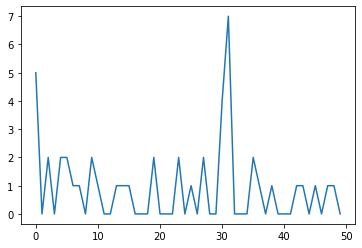

In [6]:
class DGLM(object):
    def __init__(self,m0_,C0_,Wt_,d_):
        self.m0=m0_
        self.c0=C0_
        self.wt=Wt_
        self.dtheta=d_
        self.mt=m0_
        self.ct=C0_
        self.at=m0_
        self.alphat=1
        self.betat=1
        self.rt=np.zeros(d_)
    def up_at(self,Gt):
        self.at=np.dot(Gt,self.mt)
    def up_rt(self,Gt):
        self.rt=np.dot(Gt.dot(self.ct),Gt.T)+self.wt
    def solveab(self,fq):
        sol=scipy.optimize.root(fq, np.array([1,1]), method='broyden1', tol=1e-9).x
        #sol=scipy.optimize.broyden1(fq, np.array([1,1]), f_tol=1)
        self.alphat=sol[0]
        self.betat=sol[1]
    def forecast1(self):
        return(self.alphat/(self.alphat+self.betat))
    def gt(self,zt):
        return(scipy.special.digamma(self.alphat+zt)-scipy.special.digamma(self.betat+1-zt))
    def pt(self,zt):
        return(scipy.special.polygamma(1,self.alphat+zt)+scipy.special.polygamma(1,self.betat+1-zt))
    def ft(self,Ft):
        return((Ft.T).dot(self.at))
        #return(scipy.special.digamma(self.alphat)-scipy.special.digamma(self.betat))
    def qt(self,Ft):
        return((Ft.T).dot(self.rt).dot(Ft))
    def post_up_mt(self,gtn,ftn,ptn,qtn,Ft):
        #print('g===',gtn,'f===',ftn,'p===',ptn,'q===',qtn,'F===',Ft)
        self.mt=self.at+self.rt.dot(Ft)*(gtn-ftn)/qtn
    def post_up_ct(self,gtn,ftn,ptn,qtn,Ft):
        #print('here!','self.rt:',self.rt,'Ft:',Ft,'(self.rt.dot(Ft)).dot(Ft.T):',(self.rt.dot(Ft.T)))
        self.ct=self.rt-((self.rt.dot(Ft.reshape([2,1]))).dot(Ft.reshape([1,2]))).dot(self.rt.T)*(1-ptn/qtn)/qtn
#state vector 2d
#initialization
ksi_dglm=DGLM(np.array([1,0.2]),np.identity(2),np.identity(2)/2,2)
mu_dglm=DGLM(np.array([3,4]),np.identity(2),np.identity(2)/2,2)
G_ksi_t=np.array([[0,-0.23],[0.23,0]])#rotate pi/2
G_mu_t=np.array([[0,-0.3],[0.3,0]])#rotate pi/2
F_ksi_t=np.array([1,0.5])
F_theta_t=np.array([0.3,0.4])
W_ksi_t=np.identity(2)
W_theta_t=np.identity(2)

N=50

theta0=np.array([1,2])
ksi0=np.array([3,1])
theta=theta0
ksi=ksi0

z=np.zeros(N)
y=np.zeros(N)

for t in range(N):
    lam_ksi=np.dot(F_ksi_t,ksi)
    lam_theta=np.dot(F_theta_t,theta)
    pi=scipy.special.expit(lam_ksi)
    mu=np.exp(lam_theta)
    zt=np.random.binomial(1,pi)
    z[t]=zt
    if zt==1:
        yt=1+np.random.poisson(mu)
        y[t]=yt
    #y is the output series!
    ksi=np.dot(G_ksi_t,ksi)+np.random.multivariate_normal(np.zeros(2),W_ksi_t)
    theta=np.dot(G_mu_t,theta)+np.random.multivariate_normal(np.zeros(2),W_theta_t)
plt.plot(y)
#plt.plot(y[100:299])
#plt.plot(y[300:599])
#plt.plot(y[600:899])
print(np.sum(z))


In [7]:
z_forecast=np.zeros(N)

for t in range(1,N):
    #update ksi
    ##do appendix 1 in order
    Gt=G_ksi_t
    Ft=F_ksi_t
    ksi_dglm.up_at(Gt)
    ksi_dglm.up_rt(Gt)
    #print(ksi_dglm.rt)
    #print(ksi_dglm.ct)
    ftnum=ksi_dglm.ft(Ft)
    qtnum=ksi_dglm.qt(Ft)
    def fq(ab):
        return([scipy.special.digamma(ab[0])-scipy.special.digamma(ab[1])-ftnum,scipy.special.polygamma(1,ab[0])+scipy.special.polygamma(1,ab[1])-qtnum])
    ksi_dglm.solveab(fq)
    #print(t,ksi_dglm.alphat,ksi_dglm.betat)
    z_forecast[t]=ksi_dglm.forecast1()
    gtnum=ksi_dglm.gt(z[t])
    ptnum=ksi_dglm.pt(z[t])
    ##posterior update
    ksi_dglm.post_up_mt(gtnum,ftnum,ptnum,qtnum,Ft)
    ksi_dglm.post_up_ct(gtnum,ftnum,ptnum,qtnum,Ft)
    #update mu if z=1
    if z==1:
        Gt=G
        

1 12.063065501432032 10.649671765365932
2 3.410610491562516 3.5866246916064544
3 3.5070954120750812 3.5129404323514133
4 49.63355292057256 15.202248357739421
5 2.0177935320593456 10.718858768961393
6 3.4156813240392085 3.612935308700167
7 1.901654607666696e+29 7.325048892949813e+28
8 3.486695946363271 3.523245987456969
9 2.6390088377670605e+26 2.633563187360186e+26


/Users/zhuoqunwang/anaconda3/envs/tf/lib/python3.7/site-packages/scipy/optimize/nonlin.py:999: RuntimeWarning: divide by zero encountered in true_divide
  d = v / vdot(df, v)


10 14.64846882809487 6.5109629263295705
11 3.5121422803534927 3.5124743857343477
12 3.4368877715538013 3.5852503058867398
13 -1384.3558222792713 -18945.60130469691
14 3.531263439964326 3.478694201860323
15 3.2412690971829288 3.2335549397940175
16 42.87456837303166 14.200434654662052
17 15.352377525943254 6.306614420892993
18 3.428357036174285 3.5985581175403043
19 3.4481647481446593 3.573418845759655
20 72.45824483140011 38.06385310449023
21 -65817.75639709417 -238.27651240449237
22 3.462460700956041 3.5627449775518865
23 3.1115495792357017 3.0693079332734965
24 63.7587513751455 4.117657325747777
25 3.47691461862669 3.531026777589148
26 1.7886268829781124e+45 3.473695287119425e+45
27 36.829790376675746 7.5276384927147255
28 3.5665993605735395 3.459860232755514
29 3.381683786058517 3.650185573678578
30 3.525334592704833 3.4846096212559066
31 8.282472627069149e+36 2.845858602840792e+35
32 1.7069009058767517e+33 5.672059337838055e+32
33 3.2637555372368294 3.8085112949853013
34 3.426234518

### lalal

26.0749032137192 25.0


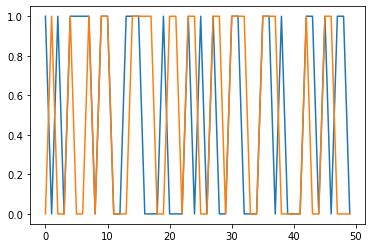

In [14]:
print(sum(z_forecast),sum(z))
plt.plot(z)
plt.plot(z_forecast>=0.5)

In [14]:
print(ksi_dglm.at)
#sol=scipy.optimize.root(fq, x0=np.array([100,100]), method='broyden1', tol=0.00000000001)
#print(sol)
#fq(sol.x)

[nan nan]


[2.694271841258575, -0.066125]

In [88]:
for i in range(1,3):
    print(i)

1
2


In [89]:
a=[1,2]

In [90]:
a.remove(1)

In [91]:
a

[2]

In [15]:
ffqq=np.zeros(1000)
sam=np.random.multivariate_normal(np.array([0,0]),np.identity(2)*10,1000)
for i in range(1000):
    ffqq[i]=np.sum(fq(sam[i]))

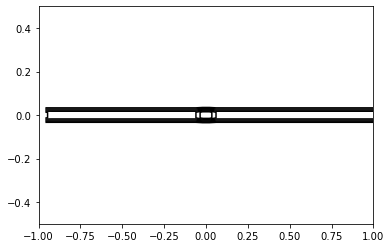

In [34]:
x = np.linspace(-1, 1, 50)
y = np.linspace(-0.5, 0.5, 40)
X, Y = np.meshgrid(x, y)
def tmp(x,y):
    #print(fq([x,y]))
    return((fq([x,y])[0])**2+(fq([x,y])[1])**2)
    
Z = tmp(X,Y)
plt.contour(X, Y, Z, colors='black');
